# 共享单车数据预测

### 1.导入数据

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_Train=pd.read_csv(r'E:\Jupyter\ShareBike\data\train.csv')
data_Test=pd.read_csv(r'E:\Jupyter\ShareBike\data\test.csv')

In [3]:
data_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [4]:
data_Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


可以看到数据完整并无缺失

### 2.特征工程

表中数据特征的实际意义如下：  
* datetime - hourly date + timestamp    
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
* holiday - whether the day is considered a holiday  
* workingday - whether the day is neither a weekend nor holiday  
* weather - 
  * 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
* temp - temperature in Celsius  
* atemp - "feels like" temperature in Celsius  
* humidity - relative humidity  
* windspeed - wind speed  
* casual - number of non-registered user rentals initiated  
* registered - number of registered user rentals initiated  
* count - number of total rentals  

### 特征分析
显然，season/holiday/workingday/weather是范围型数据，而其当前的格式为int。  
在后期进行数据可视化分析的时候，不够直观  
因此尝试对这些数据进行修改： 

In [5]:
import pylab
import calendar
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [6]:
df=data_Train.append(data_Test)
df.reset_index(inplace=True)

C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [7]:
df[['weather','season','holiday','workingday']].head()

,weather,season,holiday,workingday
0,1,1,0,0
1,1,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,1,0,0


In [8]:
#将日期符号中的‘-’替换为‘/’,方便统一分析
df['datetime']=df['datetime'].map(lambda x:x.replace('-','/'))
#日期拆分成年月日
df['date']=df.datetime.apply(lambda x:x.split( )[0])
#拆分时间为小时
df['hour']=df.datetime.apply(lambda x:x.split( )[1].split(':')[0])
#准确定义每天为周几
df['weekday']=df.date.apply(lambda x:calendar.day_name[datetime.strptime(x,"%Y/%m/%d").weekday()])
df.weekday.value_counts()
#转化月份数据为直观的月份的数据
df['month']=df.date.apply(lambda x:calendar.month_name[datetime.strptime(x,"%Y/%m/%d").month])
#替换季节的数据为直观的季节
df['season']=df.season.map({1:'Spring',2:'Summer',3:'Fall',4:'Winter'})
#替换代表气象数据的数字为实际意义
df['weather']=df.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                              2: " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                              3: " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                              4: " Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [9]:
df=df.drop(['datetime'],axis=1)

In [10]:
df.drop('index',inplace=True,axis=1)

### 数据可视化
显然上一步得到的数据中无缺失值，  
下面我们分析通过分析查看一般性规律并剔除异常值

D:\Program\Anaconda\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On Count Across Working Day')]

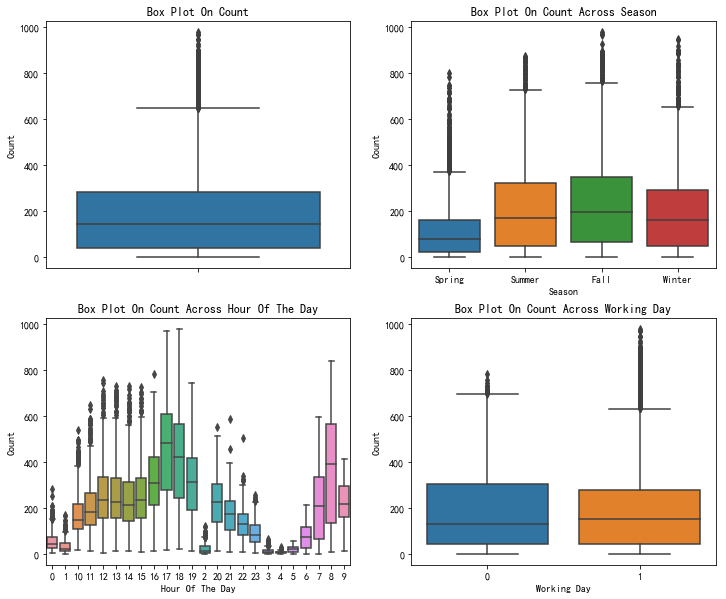

In [11]:
#用sns绘制图像
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=df.loc[:10885],y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=df.loc[:10885],y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=df.loc[:10885],y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=df.loc[:10885],y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

随后，通过matplot的形式绘图，进行对比，命令如下  
可见matplot绘图相对比较麻烦，而且色彩设置比较繁琐

In [12]:
#整理数量与日期的关系，便于绘图
data=[]
Levels = df.season.unique()
for season in Levels:
    data.append(df.iloc[0:10885].loc[df.season==season,'count'])
    print(season)

Spring
Summer
Fall
Winter


In [13]:
#整理数量count与时间的关系，便于绘图
h_data=[]
hour=df.hour.loc[0:10885].unique()
for each in hour:
    h_data.append(df.iloc[0:10885].loc[df.hour==each,'count'])

In [14]:
#整理数量与工作日的关系，便于绘图
working_data=[]
working=df['workingday'].loc[0:10885].unique()
for each in working:
    working_data.append(df.iloc[0:10885].loc[df.workingday==each,'count'])

{'boxes': [<matplotlib.patches.PathPatch at 0x24eec686908>,
 'caps': [<matplotlib.lines.Line2D at 0x24eec676e48>,
 'fliers': [<matplotlib.lines.Line2D at 0x24eec6865c0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x24eec666eb8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x24eec681908>,
  <matplotlib.lines.Line2D at 0x24eec6569e8>]}

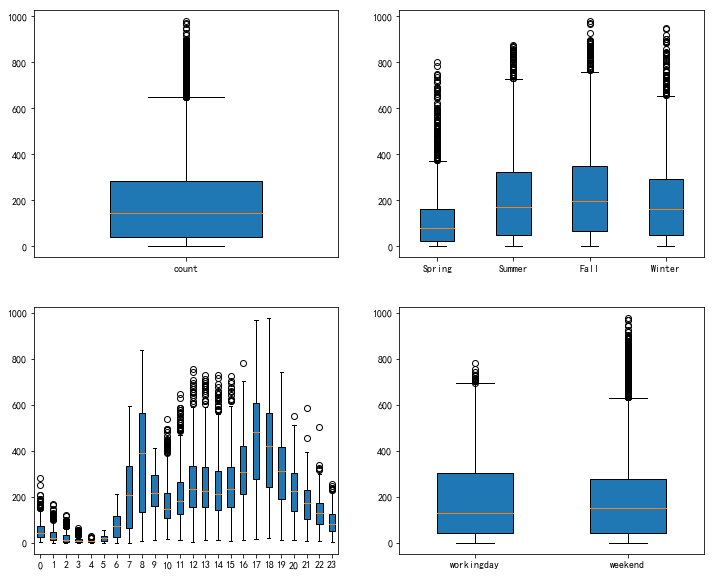

In [15]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(12, 10)

axes[0,0].boxplot(df['count'][:10885],labels=['count'],widths=0.5,patch_artist=True)
axes[0,1].boxplot(data,labels=['Spring','Summer','Fall','Winter'],patch_artist=True)
axes[1,0].boxplot(h_data,labels=hour,patch_artist=True)
axes[1,1].boxplot(working_data,labels=['workingday','weekend'],patch_artist=True,widths=0.5)

In [16]:
#除去偏差较大的数据
data_filtered=df.loc[:10885][np.abs(df['count']-df['count'].mean())<=(3*df['count'].std())]

D:\Program\Anaconda\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [17]:
data_filtered

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,weekday,month
0,14.395,3.0,16.0,0,81,13.0,Spring,9.84,Clear + Few clouds + Partly cloudy + Partly c...,0.0000,0,2011/1/1,0,Saturday,January
1,13.635,8.0,40.0,0,80,32.0,Spring,9.02,Clear + Few clouds + Partly cloudy + Partly c...,0.0000,0,2011/1/1,1,Saturday,January
2,13.635,5.0,32.0,0,80,27.0,Spring,9.02,Clear + Few clouds + Partly cloudy + Partly c...,0.0000,0,2011/1/1,2,Saturday,January
3,14.395,3.0,13.0,0,75,10.0,Spring,9.84,Clear + Few clouds + Partly cloudy + Partly c...,0.0000,0,2011/1/1,3,Saturday,January
4,14.395,0.0,1.0,0,75,1.0,Spring,9.84,Clear + Few clouds + Partly cloudy + Partly c...,0.0000,0,2011/1/1,4,Saturday,January
5,12.880,0.0,1.0,0,75,1.0,Spring,9.84,"Mist + Cloudy, Mist + Broken clouds, Mist + F...",6.0032,0,2011/1/1,5,Saturday,January
6,13.635,2.0,2.0,0,80,0.0,Spring,9.02,Clear + Few clouds + Partly cloudy + Partly c...,0.0000,0,2011/1/1,6,Saturday,January
7,12.880,1.0,3.0,0,86,2.0,Spring,8.20,Clear + Few clouds + Partly cloudy + Partly c...,0.0000,0,2011/1/1,7,Saturday,January
8,14.395,1.0,8.0,0,75,7.0,Spring,9.84,Clear + Few clouds + Partly cloudy + Partly c...,0.0000,0,2011/1/1,8,Saturday,January
9,17.425,8.0,14.0,0,76,6.0,Spring,13.12,Clear + Few clouds + Partly cloudy + Partly c...,0.0000,0,2011/1/1,9,Saturday,January


In [18]:
#查看处理后的数据量
data_filtered.shape

(10739, 15)

### 3.数据相关性分析

上面，我们通过对日期等时间数据进行了处理，划分了月，日，小时，工作日等特征  

随后，分析一下temp，atemp，humidity，windspeed与count，casual，registered之间的相关性

In [19]:
cor=df.loc[:10885][['temp','atemp','humidity','windspeed','casual','registered','count']].corr()

In [20]:
mask=np.array(cor)
mask

array([[ 1.        ,  0.98494811, -0.06494877, -0.01785201,  0.46709706,
         0.31857128,  0.39445364],
       [ 0.98494811,  1.        , -0.04353571, -0.057473  ,  0.46206654,
         0.31463539,  0.38978444],
       [-0.06494877, -0.04353571,  1.        , -0.31860699, -0.3481869 ,
        -0.26545787, -0.31737148],
       [-0.01785201, -0.057473  , -0.31860699,  1.        ,  0.09227619,
         0.09105166,  0.10136947],
       [ 0.46709706,  0.46206654, -0.3481869 ,  0.09227619,  1.        ,
         0.49724969,  0.69041357],
       [ 0.31857128,  0.31463539, -0.26545787,  0.09105166,  0.49724969,
         1.        ,  0.97094811],
       [ 0.39445364,  0.38978444, -0.31737148,  0.10136947,  0.69041357,
         0.97094811,  1.        ]])

In [21]:
mask[np.tril_indices_from(mask)]=0
mask

array([[ 0.        ,  0.98494811, -0.06494877, -0.01785201,  0.46709706,
         0.31857128,  0.39445364],
       [ 0.        ,  0.        , -0.04353571, -0.057473  ,  0.46206654,
         0.31463539,  0.38978444],
       [ 0.        ,  0.        ,  0.        , -0.31860699, -0.3481869 ,
        -0.26545787, -0.31737148],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.09227619,
         0.09105166,  0.10136947],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.49724969,  0.69041357],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.97094811],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

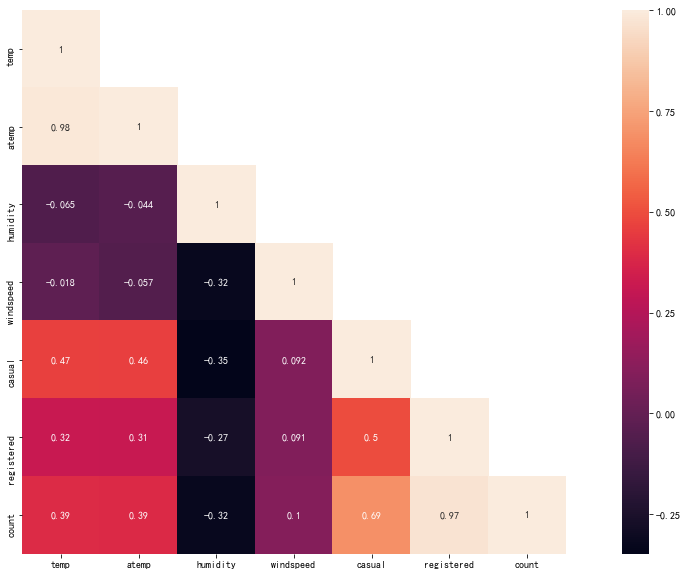

In [22]:
fig=plt.figure(figsize=(20,10))
sns.heatmap(cor,mask=mask,vmax=1,square=True,annot=True)

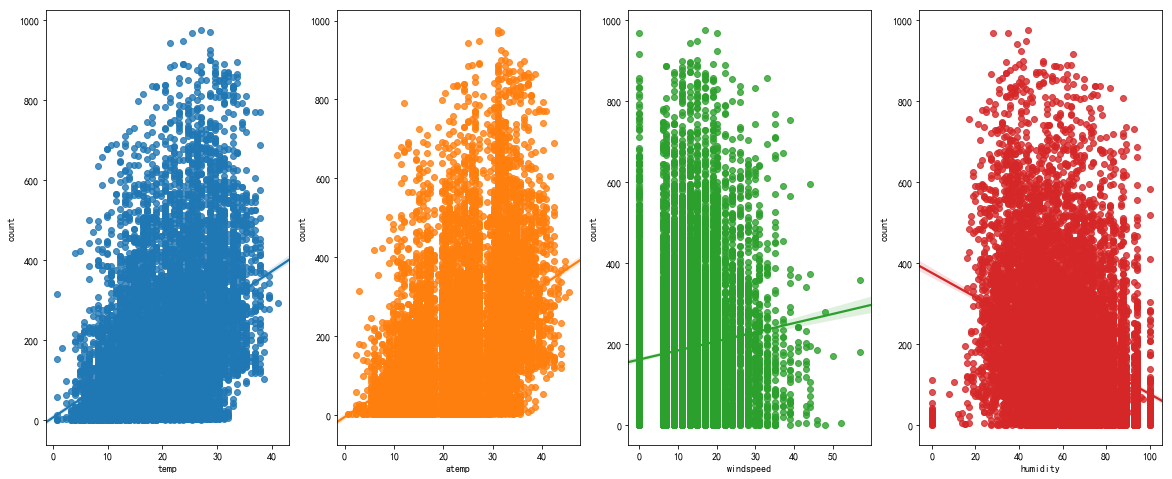

In [23]:
fig,ax=plt.subplots(1,4,figsize=(20,8))
sns.regplot(x='temp',y='count',data=df.loc[:10885],ax=ax[0])
sns.regplot(x='atemp',y='count',data=df.loc[:10885],ax=ax[1])
sns.regplot(x='windspeed',y='count',data=df.loc[:10885],ax=ax[2])
sns.regplot(x='humidity',y='count',data=df.loc[:10885],ax=ax[3])

[displot说明](http://seaborn.pydata.org/generated/seaborn.distplot.html  )    
[heatmap说明](http://seaborn.pydata.org/generated/seaborn.heatmap.html) 

气温和体感温度的趋势基本一致

### 4.可视化数据

#### 对count（结果）的数据分布分析

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([ 0.        ,  0.        ,  0.        , ...,  6.87523209,
          6.87729607,  6.88448665])),
 (1.4251967988522145, 4.5525610951779747, 0.95684956593134451))

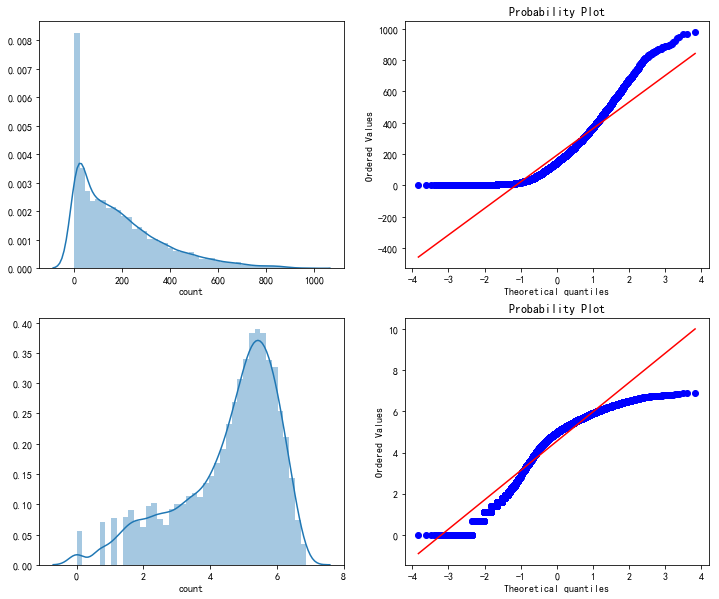

In [24]:
fig,ax=plt.subplots(2,2,figsize=(12,10))
sns.distplot(df.loc[:10885]['count'],ax=ax[0][0])
stats.probplot(df.loc[:10885]['count'],dist='norm',fit=True,plot=ax[0][1])
sns.distplot(np.log(df.loc[:10885]['count']),ax=ax[1][0])
stats.probplot(np.log(df.loc[:10885]['count']),dist='norm',fit=True,plot=ax[1][1])

可以看到原有数据方差较大，这不利于最终的模型回归  
为此，将数据进行对数化减小数据方差，  
保证了数据近似于正态分布，不像之前的结果那样存在明显的向左偏差

#### 可视化月份，季节，小时，星期、用户类型与数量的关系

In [25]:
#首先将时间重新转化成整型数据，方便后面对时间进行排序
df.hour=df.hour.astype(int)

D:\Program\Anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
D:\Program\Anaconda\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across User type'),
 None]

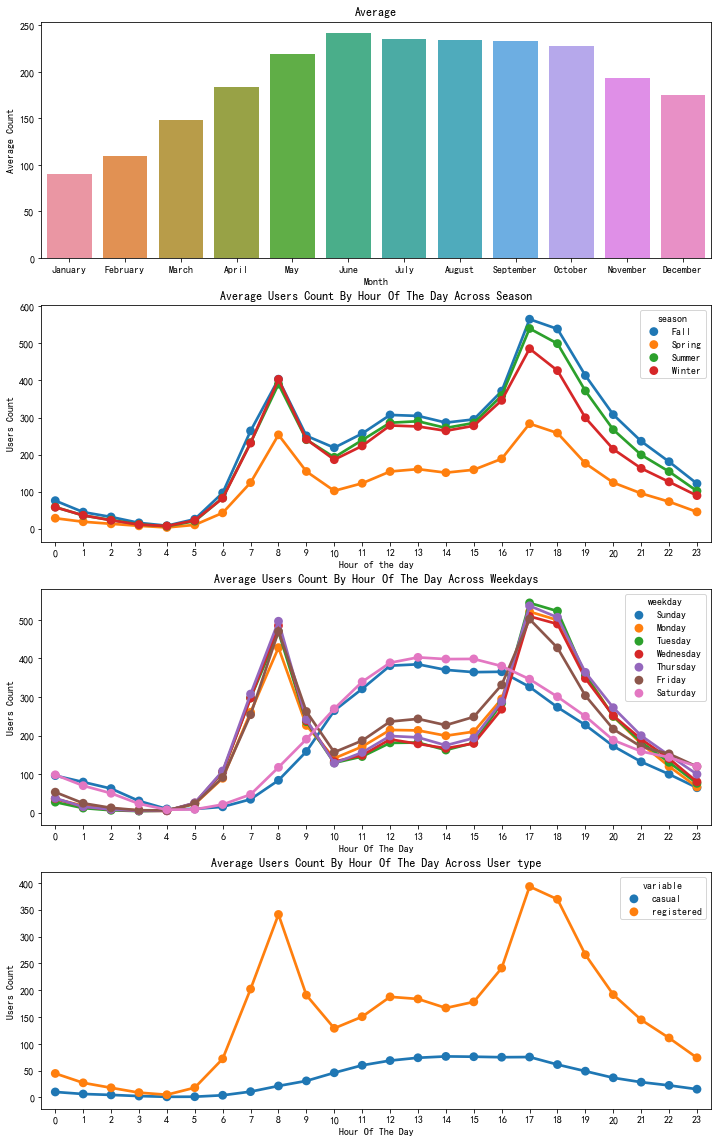

In [26]:
fig,ax=plt.subplots(4,1,figsize=(12,20))

month = ["January","February","March","April","May","June","July","August","September","October","November","December"]
week = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated=pd.DataFrame(df.loc[:10885].groupby('month')['count'].mean()).reset_index()
monthSorted=monthAggregated.sort_values(by='count',ascending=False)
sns.barplot(data=monthSorted,x='month',y='count',ax=ax[0],order=month)
ax[0].set(xlabel='Month',ylabel='Average Count',title='Average',label='big')

hourAggregated=pd.DataFrame(df.loc[:10885].groupby(['hour','season'],sort=True)['count'].mean()).reset_index().sort_values(by='hour')
sns.pointplot(x=hourAggregated['hour'],y=hourAggregated['count'],hue=hourAggregated["season"],data=hourAggregated, join=True,ax=ax[1])
ax[1].set(xlabel='Hour of the day',ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated=pd.DataFrame(df.loc[:10885].groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index().sort_values(by='hour')
sns.pointplot(x=hourAggregated['hour'],y=hourAggregated['count'],
              hue=hourAggregated['weekday'],hue_order=week,
              data=hourAggregated,join=True,ax=ax[2])
ax[2].set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed=pd.melt(df.loc[:10885][['hour','casual','registered']],id_vars=['hour'],value_vars=['casual','registered'])
hourAggregated=pd.DataFrame(hourTransformed.groupby(['hour','variable'],sort=True)['value'].mean()).reset_index().sort_values(by='hour')
sns.pointplot(x=hourAggregated['hour'],y=hourAggregated['value'],hue=hourAggregated['variable'],hue_order=['casual','registered'],data=hourAggregated,join=True)
ax[3].set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User type",label='big')

Text(0.5,1,'user count compare between casual and registered users')

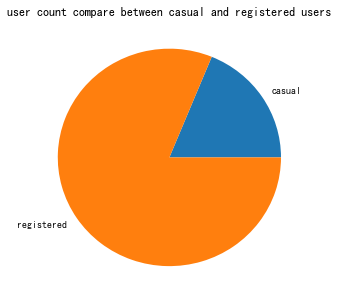

In [27]:
fig=plt.subplots(figsize=(5,5))
casual=df.loc[:10885,'casual'].sum()
registered=df.loc[:10885,'registered'].sum()
plt.pie([casual,registered],labels=['casual','registered'])
#plt.grid(True)
#plt.xlabel('user type')
#plt.ylabel('user count')
plt.title('user count compare between casual and registered users')

显然，基于上述结果，我们得到如下规律：  
1.用户用车数量春秋天明天高于冬夏，冬天的用车数量最少；  
2.一天内，用车存在早晚两个高峰期，这与上下班的时间重合；  
3.有别于工作日的用车规律，周末用车数量在早晨8点后开始上升，并在未来的10个小时内保持一个较高的数量；  
4.显然注册用户的用车规律与工作日的用车曲线规律一致，这反映了注册用户普遍将共享单车作为了一种出行工具；  
5.非注册用户则可能是出于娱乐等其他方面的需求。 
6.注册用户数量明显高于非注册用户，约为4倍，这说明将单车用于工作的人比娱乐的人数要多；


### 5.修正windspeed数据

通过对数据进行观察发现，尽管数据完整，但在风速数据中，为0的数据超过1300个
显然，这部分数据信息有误，因此有必要根据已有的信息进行分析

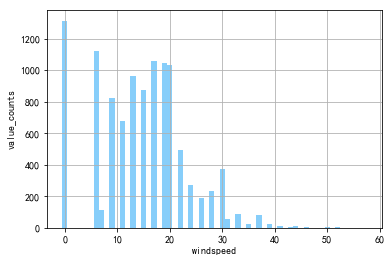

In [28]:
windspeed=df.loc[:10885].windspeed
plt.bar(windspeed.unique(),windspeed.value_counts(),width=1,color="#87CEFA")
plt.xlabel('windspeed')
plt.ylabel('value_counts')
plt.grid(True)

显然，风速的结果与season，weather，humidity，month，temp，year，atemp有关。
而这其中的season，weather，month，year已经在之前处理过，  
为进行预测，有必要将数据重新转化为数值型数据

In [29]:
df.season=df.season.map({'Spring':1,'Summer':2,'Fall':3,'Winter':4})

In [30]:
#转化数值类型便于进行模型回归
df.weather=df.weather.map({' Clear + Few clouds + Partly cloudy + Partly cloudy':1,
                ' Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ':2,
                ' Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds':3,
                ' Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog ':4})

df.month=df.month.map({'April': 4,'August': 8,'December': 12,'February': 2,
                       'January': 1,'July': 7,'June': 6,'March': 3,
                       'May': 5,'November': 11,'October': 10,'September': 9})

df['year']=df.date.apply(lambda x:x.split('/')[0])

df.weekday=df.weekday.map({'Saturday':6, 'Sunday':7, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4,'Friday':5})

In [31]:
df.head(1)

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,weekday,month,year
0,14.395,3.0,16.0,0,81,13.0,1,9.84,1,0.0,0,2011/1/1,0,6,1,2011


In [32]:
#导入集成学习中的随机深林算法构建模型进行拟合
from sklearn.ensemble import RandomForestRegressor
datawind0=df[df['windspeed']==0]
datawindn0=df[df['windspeed']!=0]
model=RandomForestRegressor()

#模型拟合
windfactors=["season","weather","humidity","month","temp","year","atemp"]
model.fit(datawindn0[windfactors],datawindn0['windspeed'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [33]:
#风速结果预测
windvalue=model.predict(datawind0[windfactors])
datawind0['windspeed']=windvalue
data=datawindn0.append(datawind0)

D:\Program\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [34]:
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

显然，进行风速回归后的结果更加准确

### 6.结果预测

在上面对数据进行处理后，将数据拆分成训练集和测试集

In [35]:
data.head(1)

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,weekday,month,year
0,12.88,0.0,1.0,0,75,1.0,1,9.84,2,6.0032,0,2011/1/1,5,6,1,2011


In [36]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=['date','hour'])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=['date','hour']) #~符号代表的是补集的意思,这里意思是‘count’为空数据集
datetimecol = data_Test['datetime'].replace('/','-')
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

In [37]:
dataTrain=dataTrain.drop(['casual','registered','count','date'],axis=1)
dataTest=dataTest.drop(['casual','registered','count','date'],axis=1)  

In [38]:
#本次竞赛官方提供的误差计算函数
def rmsle(y,y_,convertExp=True):
    if convertExp:
        y=np.exp(y)
        y_=np.exp(y_)
    log1=np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2=np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc=(log1-log2)**2
    return np.sqrt(np.mean(calc))

线性回归模型分析

In [39]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment=None
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [40]:
#初始化逻辑回归模型
model1=LinearRegression()

#训练模型
yLabelslog=np.log1p(yLabels)
model1.fit(dataTrain,yLabelslog)

#将当前的已有数据的预测值与实际值对比，计算误差。
#最终模拟结果也是这样评分的
preds=model1.predict(dataTrain)
print('RMSLE 值分析',rmsle(preds,yLabelslog))

RMSLE 值分析 0.977959172158


正则化模型-岭回归（Ridge）

In [41]:
#构建模型，ridge岭回归，GridsearchCV交叉验证获得不同alpha下的最优的拟合结果，ridge是二阶范数
model_r=Ridge()
ridge_params={'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer=metrics.make_scorer(rmsle,greater_is_better=False)
model_g=GridSearchCV(model_r,
                         ridge_params,
                         scoring=rmsle_scorer,
                         cv=5)

#训练模型
yLabelslog=np.log1p(yLabels)
model_g.fit(dataTrain,yLabelslog)

#查看模型的拟合效果
preds=model_g.predict(dataTrain)
print('RMSLE 值分析',rmsle(preds,yLabelslog))

RMSLE 值分析 0.978326250198


D:\Program\Anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


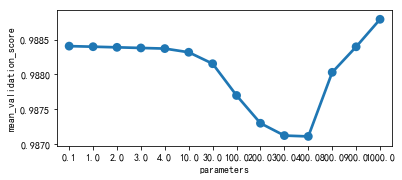

In [42]:
fig,ax=plt.subplots(figsize=(6,2.5))
df1=pd.DataFrame(model_g.grid_scores_)
alpha=df1.parameters.apply(lambda x:x['alpha'])
score=df1.mean_validation_score.apply(lambda x:-x)
sns.pointplot(alpha,score,ax=ax)

正则化模型-Lasso

In [43]:
#构建模型，Lasso是一阶范数
model_l=Lasso()

alpha=1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params={'max_iter':[3000],'alpha':alpha}

model_gl=GridSearchCV(model_l,
                      lasso_params,
                     scoring=rmsle_scorer,
                     cv=5)

#训练模型
yLabelslog=np.log1p(yLabels)
model_gl.fit(dataTrain,yLabelslog)

#查看模型的拟合效果
preds=model_gl.predict(dataTrain)
print('RMSLE 值分析',rmsle(preds,yLabelslog))

RMSLE 值分析 0.978214656155


D:\Program\Anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


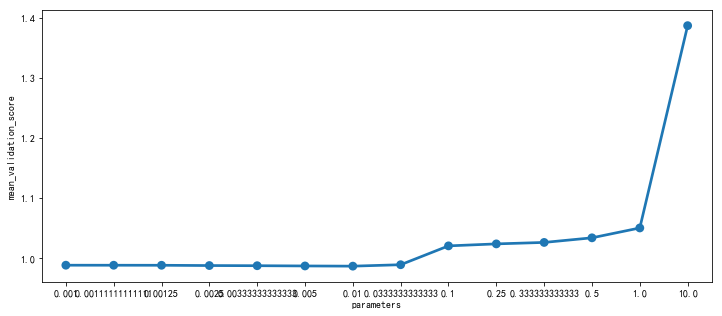

In [44]:
fig,ax=plt.subplots(figsize=(12,5))
df2=pd.DataFrame(model_gl.grid_scores_)
alpha=df2.parameters.apply(lambda x:x['alpha'])
score=df2.mean_validation_score.apply(lambda x:-x)
sns.pointplot(alpha,score,ax=ax)

集成化模型-RF

In [45]:
#为了直观说明，再次导入随机森林函数,构建模型
from sklearn.ensemble import RandomForestRegressor
model_RF=RandomForestRegressor(n_estimators=100)

#训练模型
yLabelslog=np.log1p(yLabels)
model_RF.fit(dataTrain,yLabelslog)

#查看模型的拟合效果
preds=model_RF.predict(dataTrain)
print('RMSLE 值分析',rmsle(preds,yLabelslog))

RMSLE 值分析 0.103272050217


集成化模型-梯度上升（Gradient Boost）

In [46]:
#导入模型，构建模型
from sklearn.ensemble import GradientBoostingRegressor
model_GB=GradientBoostingRegressor(n_estimators=4000,alpha=0.01)

#训练模型
yLabelslog=np.log1p(yLabels)
model_GB.fit(dataTrain,yLabelslog)

#查看模型的拟合效果
preds=model_GB.predict(dataTrain)
print('RMSLE 值分析',rmsle(preds,yLabelslog))

RMSLE 值分析 0.189423623632


显然，通过集成算法后的结果明显优于单模型计算的结果，  
且从RMSLE的结果来看，随机森林（RF）的预测结果明显优于GB算法的结果

In [47]:
#获得预测结果
predsTest_RF=model_RF.predict(dataTest)
predsTest_GB=model_GB.predict(dataTest)

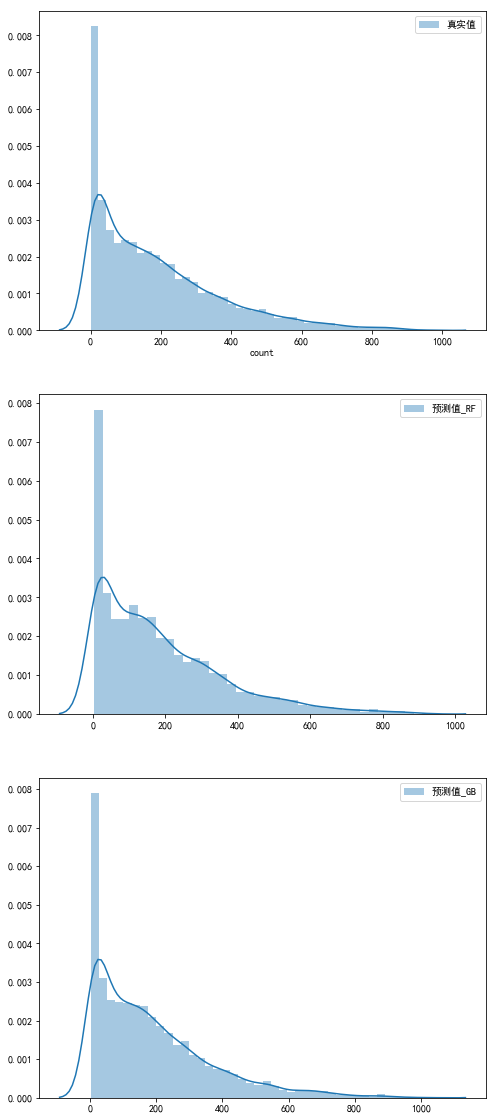

In [48]:
fig,ax=plt.subplots(3,1,figsize=(8,20))
sns.distplot(yLabels,ax=ax[0],label='真实值').legend()
sns.distplot(np.exp(predsTest_RF),ax=ax[1],label='预测值_RF').legend()
sns.distplot(np.exp(predsTest_GB),ax=ax[2],label='预测值_GB').legend()

In [49]:
#生成数据格式
submission=pd.DataFrame({
                        'datetime':datetimecol,
                        'count':[max(0,x) for x in np.exp(predsTest_RF)]})

#导出数据
submission.to_csv(r'E:\Jupyter\ShareBike\data\Submission_RF.csv',index=False)

数据提交到kaggle，最终得分0.436分